## Import Stuff

In [7]:
import pandas as pd
import numpy as np
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, LayerNormalization
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import keras_tuner as kt
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix, roc_curve
import matplotlib.pyplot as plt

## Model Variables

In [8]:
rolling_window   = 50    # length of the input sequence
epochs           = 10
batch_size       = 32

# Manual hyperparameters (for “manual tuning”)
rnn_units        = 64
learning_rate    = 1e-3

## Data Pre-processing

In [9]:
# Load and prepare data
combined_stocks_df = pd.read_csv("../filtered_stocks_combined.csv")

# Convert Date to datetime and set as index
combined_stocks_df["Date"] = pd.to_datetime(combined_stocks_df["Date"])
combined_stocks_df.set_index("Date", inplace=True)

# Drop unnecessary columns if any
combined_stocks_df = combined_stocks_df.drop(columns=["index"])  # Optional

# Pivot to multi-level columns: Ticker as level 1, feature as level 2
stocks_df = combined_stocks_df.pivot_table(
    index=combined_stocks_df.index,
    columns="ticker",
    values=[col for col in combined_stocks_df.columns if col != "ticker"]
)

# Sort columns for clarity
stocks_df = stocks_df.sort_index(axis=1, level=0)

# Swap the column MultiIndex levels
stocks_df_leveled = stocks_df.swaplevel(axis=1)

# Sort by ticker (Level 0)
stocks_df_leveled = stocks_df_leveled.sort_index(axis=1, level=0)

## Dataset Split

In [10]:
#Time-based split into 60% train, 20% val, 20% test
train_dict, val_dict, test_dict = {}, {}, {}

# Time-based split into 60% train, 20% val, 20% test
train_dict, val_dict, test_dict = {}, {}, {}

# Compute Logarithmic Returns, split into train, val and test sets
for ticker in stocks_df_leveled.columns.levels[0]:
    stocks_df_leveled.loc[:, (ticker, 'log_return')] = np.log(
        stocks_df_leveled[ticker]['Close'] / stocks_df_leveled[ticker]['Close'].shift(1)
    )

    df = stocks_df_leveled[ticker].dropna().sort_index()
    total_len = len(df)
    train_end = int(total_len * 0.6)
    val_end = train_end + int(total_len * 0.2)

    train_dict[ticker] = df.iloc[:train_end]
    val_dict[ticker] = df.iloc[train_end:val_end]
    test_dict[ticker] = df.iloc[val_end:]

train_df = pd.concat(train_dict, names=["Ticker", "Date"])
val_df = pd.concat(val_dict, names=["Ticker", "Date"])
test_df = pd.concat(test_dict, names=["Ticker", "Date"])

## Feature Scaling & Extraction

In [11]:
# Define features and binary classification target
features = ['Open', 'High', 'Low', 'Close', 'Volume']
train_df['target'] = (train_df['log_return'] > 0).astype(int)
val_df['target'] = (val_df['log_return'] > 0).astype(int)
test_df['target'] = (test_df['log_return'] > 0).astype(int)

# Extract features and target
X_train = train_df[features]
y_train = train_df['target']
X_val = val_df[features]
y_val = val_df['target']
X_test = test_df[features]
y_test = test_df['target']

# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

print(X_test_scaled)

[[ 0.70832579  0.73573349  0.71524614  0.74380959  0.79802262]
 [ 0.74724251  0.75608693  0.7577544   0.74365754  0.61620678]
 [ 0.75180306  0.7548808   0.76358586  0.76874545  0.59778391]
 ...
 [ 0.4136229   0.40884224  0.41920757  0.4079205  -0.36326138]
 [ 0.40515548  0.40143962  0.41581612  0.40863512 -0.36052951]
 [ 0.40410655  0.40288698  0.41553989  0.40731231 -0.29423036]]


## Create RNN Sequences

In [12]:
def create_sequences(X, y, window):
    Xs, ys = [], []
    for i in range(len(X) - window):
        Xs.append(X[i:i+window])
        ys.append(y[i+window])
    return np.array(Xs), np.array(ys)

# convert to numpy arrays
y_train_arr = y_train.values
y_val_arr   = y_val.values
y_test_arr  = y_test.values

# build sequences
X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train_arr, rolling_window)
X_val_seq,   y_val_seq   = create_sequences(X_val_scaled,   y_val_arr,   rolling_window)
X_test_seq,  y_test_seq  = create_sequences(X_test_scaled,  y_test_arr,  rolling_window)
X_train_seq

array([[[-0.26703953, -0.27245509, -0.27022423, -0.26965071,
          1.71810283],
        [-0.27188892, -0.26886686, -0.26756939, -0.26438986,
          1.31218769],
        [-0.26212934, -0.26713305, -0.26087855, -0.26489161,
          1.65206891],
        ...,
        [-0.22734753, -0.22613972, -0.22469282, -0.22628664,
          2.64857337],
        [-0.24885813, -0.24278431, -0.24676029, -0.24214524,
          4.72968661],
        [-0.24884293, -0.25213181, -0.27390726, -0.27215951,
          7.8978525 ]],

       [[-0.27188892, -0.26886686, -0.26756939, -0.26438986,
          1.31218769],
        [-0.26212934, -0.26713305, -0.26087855, -0.26489161,
          1.65206891],
        [-0.26387755, -0.26500724, -0.26285818, -0.26023895,
          1.7278263 ],
        ...,
        [-0.24885813, -0.24278431, -0.24676029, -0.24214524,
          4.72968661],
        [-0.24884293, -0.25213181, -0.27390726, -0.27215951,
          7.8978525 ],
        [-0.25838969, -0.25869014, -0.26526749, 

## Autotuner Model (Base)

In [13]:
def build_model_hp(hp):
    units = hp.Int('units', 16, 128, step=16)
    lr    = hp.Float('lr', 1e-4, 1e-2, sampling='log')
    model = Sequential([
        SimpleRNN(units, input_shape=(rolling_window, len(features))),
        Dense(1, activation='sigmoid')
    ])
    model.compile(
        optimizer=Adam(learning_rate=lr),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

tuner = kt.RandomSearch(
    build_model_hp,
    objective='val_accuracy',
    max_trials=5,
    executions_per_trial=1,
    directory='rnn_tuner',
    project_name='stock_class_rnn'
)

tuner.search(
    X_train_seq, y_train_seq,
    epochs=5,
    batch_size=batch_size,
    validation_data=(X_val_seq, y_val_seq)
)

best_hp   = tuner.get_best_hyperparameters(num_trials=1)[0]
auto_model = tuner.hypermodel.build(best_hp)
history_auto = auto_model.fit(
    X_train_seq, y_train_seq,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(X_val_seq, y_val_seq)
)


Reloading Tuner from rnn_tuner\stock_class_rnn\tuner0.json
Epoch 1/10


c:\Users\djleong01\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1413/1413 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5002 - loss: 0.7091 - val_accuracy: 0.5127 - val_loss: 0.6936
Epoch 2/10
1413/1413 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.5024 - loss: 0.7054 - val_accuracy: 0.4973 - val_loss: 0.7365
Epoch 3/10
1413/1413 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.5041 - loss: 0.7060 - val_accuracy: 0.5131 - val_loss: 0.7028
Epoch 4/10
1413/1413 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.5071 - loss: 0.7038 - val_accuracy: 0.4874 - val_loss: 0.7006
Epoch 5/10
1413/1413 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.5011 - loss: 0.7089 - val_accuracy: 0.4916 - val_loss: 0.7155
Epoch 6/10
1413/1413 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.5110 - loss: 0.7006 - val_accuracy: 0.5066 - val_loss: 0.6945
Epoch 7/10
1413/1413 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.4982 - loss: 0.7058 - val_accuracy: 0.5029 - val_loss: 0.7151
Epoch 8/10
1413/1413 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.5074 - loss: 0.7014 - val_accurac

### Result Analysis & Evaluation

472/472 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
472/472 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Auto‑Tuned Model:
  True Positives (correct UP)  : 7799
  True Negatives (correct DOWN): 0


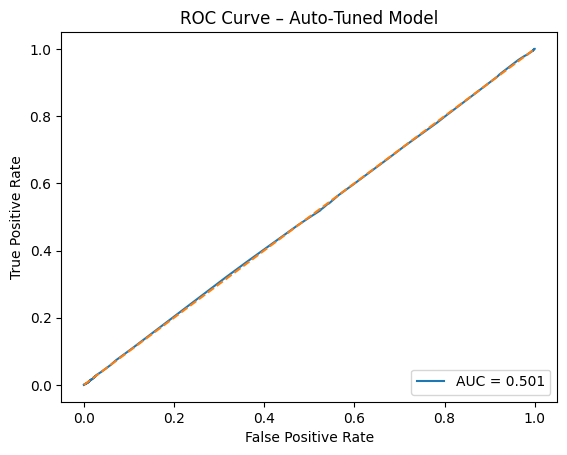

In [14]:
# 1) Compute actual counts
actual_up = (y_test_seq == 1).sum()
actual_down = (y_test_seq == 0).sum()

# 3) Auto model predictions & counts
y_prob_auto = auto_model.predict(X_test_seq).ravel()
y_pred_auto = (y_prob_auto > 0.5).astype(int)
pred_up_auto   = y_pred_auto.sum()
pred_down_auto = len(y_pred_auto) - pred_up_auto

# Auto‑tuned model counts
y_prob_auto  = auto_model.predict(X_test_seq).ravel()
y_pred_auto  = (y_prob_auto > 0.5).astype(int)

tp_auto = ((y_pred_auto == 1) & (y_test_seq == 1)).sum()
tn_auto = ((y_pred_auto == 0) & (y_test_seq == 0)).sum()

print("Auto‑Tuned Model:")
print(f"  True Positives (correct UP)  : {tp_auto}")
print(f"  True Negatives (correct DOWN): {tn_auto}")

# 6) Plot ROC for Auto‑tuned model
fpr_a, tpr_a, _ = roc_curve(y_test_seq, y_prob_auto)
auc_a = roc_auc_score(y_test_seq, y_prob_auto)

plt.figure()
plt.plot(fpr_a, tpr_a, label=f'AUC = {auc_a:.3f}')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve – Auto‑Tuned Model')
plt.legend(loc='lower right')
plt.show()

## Auto Tuner (With 1 dense layer)

In [15]:
def build_model_hp(hp):
    # Hyperparameters to search:
    num_rnn     = hp.Int('num_rnn_layers',   1, 3)             # 1 to 3 stacked RNNs
    rnn_units   = hp.Int('rnn_units',        16, 128, step=16)
    lr          = hp.Float('lr',             1e-4, 1e-2, sampling='log')
    dense_units = hp.Int('dense_units',      0, 64,  step=16)  # 0 = no dense layer

    model = Sequential()
    # Stack RNN layers
    for i in range(num_rnn):
        return_seq = (i < num_rnn - 1)
        if i == 0:
            model.add(SimpleRNN(
                rnn_units,
                return_sequences=return_seq,
                input_shape=(rolling_window, len(features))
            ))
        else:
            model.add(SimpleRNN(rnn_units, return_sequences=return_seq))

    # Optional hidden Dense layer
    if dense_units > 0:
        model.add(Dense(dense_units, activation='relu'))

    # Output layer
    model.add(Dense(1, activation='sigmoid'))

    model.compile(
        optimizer=Adam(learning_rate=lr),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

tuner = kt.RandomSearch(
    build_model_hp,
    objective='val_accuracy',
    max_trials=5,                # increase trials to cover more combos
    executions_per_trial=1,
    directory='rnn_tuner',
    project_name='stock_class_rnn_hidden'
)

tuner.search(
    X_train_seq, y_train_seq,
    epochs=5,
    batch_size=batch_size,
    validation_data=(X_val_seq, y_val_seq)
)

best_hp   = tuner.get_best_hyperparameters(num_trials=1)[0]
auto_model = tuner.hypermodel.build(best_hp)

history_auto = auto_model.fit(
    X_train_seq, y_train_seq,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(X_val_seq, y_val_seq)
)


Reloading Tuner from rnn_tuner\stock_class_rnn_hidden\tuner0.json
Epoch 1/10


c:\Users\djleong01\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1413/1413 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.5086 - loss: 0.6955 - val_accuracy: 0.4991 - val_loss: 0.6938
Epoch 2/10
1413/1413 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.5193 - loss: 0.6934 - val_accuracy: 0.5103 - val_loss: 0.6945
Epoch 3/10
1413/1413 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.5162 - loss: 0.6931 - val_accuracy: 0.5131 - val_loss: 0.6935
Epoch 4/10
1413/1413 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.5218 - loss: 0.6926 - val_accuracy: 0.5145 - val_loss: 0.6945
Epoch 5/10
1413/1413 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.5215 - loss: 0.6928 - val_accuracy: 0.5095 - val_loss: 0.6933
Epoch 6/10
1413/1413 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.5238 - loss: 0.6922 - val_accuracy: 0.4989 - val_loss: 0.6940
Epoch 7/10
1413/1413 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.5158 - loss: 0.6925 - val_accuracy: 0.5092 - val_loss: 0.6936
Epoch 8/10
1413/1413 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.5044 - loss: 0.6962 - val_accura

### Results & Analysis

472/472 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
472/472 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Auto‑Tuned Model:
  True Positives (correct UP)  : 6867
  True Negatives (correct DOWN): 844
  False Positives (incorrect UP): 6457
  False Negatives (incorrect DOWN): 932
  Accuracy: 0.511


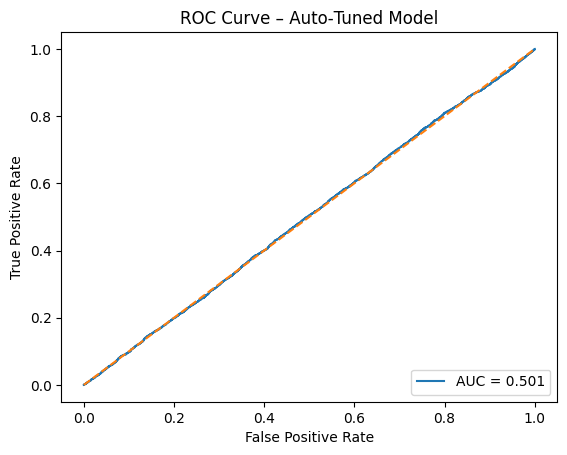

In [16]:
# 1) Compute actual counts
actual_up = (y_test_seq == 1).sum()
actual_down = (y_test_seq == 0).sum()

# 3) Auto model predictions & counts
y_prob_auto = auto_model.predict(X_test_seq).ravel()
y_pred_auto = (y_prob_auto > 0.5).astype(int)
pred_up_auto   = y_pred_auto.sum()
pred_down_auto = len(y_pred_auto) - pred_up_auto

# Auto‑tuned model counts
y_prob_auto  = auto_model.predict(X_test_seq).ravel()
y_pred_auto  = (y_prob_auto > 0.5).astype(int)

tp_auto = ((y_pred_auto == 1) & (y_test_seq == 1)).sum()
tn_auto = ((y_pred_auto == 0) & (y_test_seq == 0)).sum()

print("Auto‑Tuned Model:")
print(f"  True Positives (correct UP)  : {tp_auto}")
print(f"  True Negatives (correct DOWN): {tn_auto}")
print(f"  False Positives (incorrect UP): {pred_up_auto - tp_auto}")
print(f"  False Negatives (incorrect DOWN): {pred_down_auto - tn_auto}")

acc_auto = accuracy_score(y_test_seq, y_pred_auto)
print(f"  Accuracy: {acc_auto:.3f}")
# 6) Plot ROC for Auto‑tuned model
fpr_a, tpr_a, _ = roc_curve(y_test_seq, y_prob_auto)
auc_a = roc_auc_score(y_test_seq, y_prob_auto)

plt.figure()
plt.plot(fpr_a, tpr_a, label=f'AUC = {auc_a:.3f}')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve – Auto‑Tuned Model')
plt.legend(loc='lower right')
plt.show()

## RNN with Layer Normalization

In [17]:
def build_model_hp(hp):
    # RNN layer hyperparameters
    num_rnn    = hp.Int('num_rnn_layers', 1, 3)
    rnn_units  = hp.Int('rnn_units',       32, 128, step=32)
    
    # Dense layer hyperparameters
    num_dense  = hp.Int('num_dense_layers', 0, 2)
    dense_units = hp.Int('dense_units',     16, 64, step=16)
    
    # Learning rate & gradient clipping
    lr         = hp.Float('lr', 1e-4, 1e-2, sampling='log')
    clip_norm  = hp.Float('clipnorm', 0.5, 2.0, step=0.5)
    
    model = Sequential()
    
    # Stack RNNs with LayerNorm
    for i in range(num_rnn):
        return_seq = (i < num_rnn - 1)
        if i == 0:
            model.add(SimpleRNN(
                rnn_units,
                return_sequences=return_seq,
                input_shape=(rolling_window, len(features))
            ))
        else:
            model.add(SimpleRNN(rnn_units, return_sequences=return_seq))
        model.add(LayerNormalization())
    
    # Optional Dense hidden layers
    for _ in range(num_dense):
        model.add(Dense(dense_units, activation='relu'))
    
    # Final output
    model.add(Dense(1, activation='sigmoid'))
    
    optimizer = Adam(learning_rate=lr, clipnorm=clip_norm)
    model.compile(
        optimizer=optimizer,
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

tuner = kt.RandomSearch(
    build_model_hp,
    objective='val_accuracy',
    max_trials=10,               # explore more combinations
    executions_per_trial=1,
    directory='rnn_tuner_norm',
    project_name='stock_rnn_norm'
)

tuner.search(
    X_train_seq, y_train_seq,
    epochs=5,
    batch_size=batch_size,
    validation_data=(X_val_seq, y_val_seq)
)

# Build & train best model
best_hp   = tuner.get_best_hyperparameters(1)[0]
auto_model = tuner.hypermodel.build(best_hp)

history_auto = auto_model.fit(
    X_train_seq, y_train_seq,
    epochs=epochs, batch_size=batch_size,
    validation_data=(X_val_seq, y_val_seq)
)

Reloading Tuner from rnn_tuner_norm\stock_rnn_norm\tuner0.json
Epoch 1/10


c:\Users\djleong01\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1413/1413 ━━━━━━━━━━━━━━━━━━━━ 17s 11ms/step - accuracy: 0.5023 - loss: 0.7034 - val_accuracy: 0.5061 - val_loss: 0.6988
Epoch 2/10
1413/1413 ━━━━━━━━━━━━━━━━━━━━ 15s 11ms/step - accuracy: 0.5138 - loss: 0.6944 - val_accuracy: 0.5071 - val_loss: 0.6933
Epoch 3/10
1413/1413 ━━━━━━━━━━━━━━━━━━━━ 15s 11ms/step - accuracy: 0.5078 - loss: 0.6938 - val_accuracy: 0.5103 - val_loss: 0.6934
Epoch 4/10
1413/1413 ━━━━━━━━━━━━━━━━━━━━ 15s 10ms/step - accuracy: 0.5105 - loss: 0.6937 - val_accuracy: 0.5098 - val_loss: 0.6934
Epoch 5/10
1413/1413 ━━━━━━━━━━━━━━━━━━━━ 18s 13ms/step - accuracy: 0.5206 - loss: 0.6931 - val_accuracy: 0.5127 - val_loss: 0.6931
Epoch 6/10
1413/1413 ━━━━━━━━━━━━━━━━━━━━ 15s 11ms/step - accuracy: 0.5101 - loss: 0.6930 - val_accuracy: 0.5107 - val_loss: 0.6934
Epoch 7/10
1413/1413 ━━━━━━━━━━━━━━━━━━━━ 15s 10ms/step - accuracy: 0.5156 - loss: 0.6931 - val_accuracy: 0.5117 - val_loss: 0.6932
Epoch 8/10
1413/1413 ━━━━━━━━━━━━━━━━━━━━ 15s 11ms/step - accuracy: 0.5184 - loss: 0.69

### Results & Analysis

472/472 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
472/472 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
Auto‑Tuned Model:
  True Positives (correct UP)  : 7303
  True Negatives (correct DOWN): 447
  False Positives (incorrect UP): 6854
  False Negatives (incorrect DOWN): 496
  Accuracy: 0.513


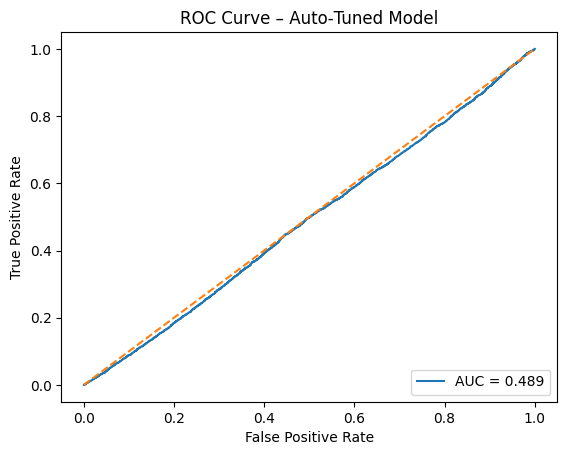

In [18]:
# 1) Compute actual counts
actual_up = (y_test_seq == 1).sum()
actual_down = (y_test_seq == 0).sum()

# 3) Auto model predictions & counts
y_prob_auto = auto_model.predict(X_test_seq).ravel()
y_pred_auto = (y_prob_auto > 0.5).astype(int)
pred_up_auto   = y_pred_auto.sum()
pred_down_auto = len(y_pred_auto) - pred_up_auto

# Auto‑tuned model counts
y_prob_auto  = auto_model.predict(X_test_seq).ravel()
y_pred_auto  = (y_prob_auto > 0.5).astype(int)

tp_auto = ((y_pred_auto == 1) & (y_test_seq == 1)).sum()
tn_auto = ((y_pred_auto == 0) & (y_test_seq == 0)).sum()

print("Auto‑Tuned Model:")
print(f"  True Positives (correct UP)  : {tp_auto}")
print(f"  True Negatives (correct DOWN): {tn_auto}")
print(f"  False Positives (incorrect UP): {pred_up_auto - tp_auto}")
print(f"  False Negatives (incorrect DOWN): {pred_down_auto - tn_auto}")

acc_auto = accuracy_score(y_test_seq, y_pred_auto)
print(f"  Accuracy: {acc_auto:.3f}")
# 6) Plot ROC for Auto‑tuned model
fpr_a, tpr_a, _ = roc_curve(y_test_seq, y_prob_auto)
auc_a = roc_auc_score(y_test_seq, y_prob_auto)

plt.figure()
plt.plot(fpr_a, tpr_a, label=f'AUC = {auc_a:.3f}')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve – Auto‑Tuned Model')
plt.legend(loc='lower right')
plt.show()

In [1]:

import pandas as pd
import numpy as np
import keras_tuner as kt
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, LayerNormalization
from tensorflow.keras.optimizers import Adam

from sklearn.metrics import (accuracy_score, f1_score, roc_auc_score, confusion_matrix, roc_curve)


In [2]:
df = pd.read_csv("../filtered_stocks_combined.csv", parse_dates=['Date'])
df = df.sort_values(['Date','ticker']).reset_index(drop=True)

# Log‐return and binary target
df['log_return'] = np.log(df.groupby('ticker')['Close'].pct_change()+1)
df['target']     = (df['log_return'] > 0).astype(int)
df = df.dropna(subset=['log_return']).reset_index(drop=True)

features = ['Open','High','Low','Volume']
X_all    = df[features].values
y_all    = df['target'].values

# 60/20/20 time‐based split
n_total = len(df)
n_train = int(n_total * 0.6)
n_val   = int(n_total * 0.2)

X_train = X_all[:n_train]
y_train = y_all[:n_train]

X_val   = X_all[n_train:n_train+n_val]
y_val   = y_all[n_train:n_train+n_val]

X_test  = X_all[n_train+n_val:]
y_test  = y_all[n_train+n_val:]


In [3]:
# Standardize features
scaler      = StandardScaler()
X_train_scl = scaler.fit_transform(X_train)
X_val_scl   = scaler.transform(X_val)
X_test_scl  = scaler.transform(X_test)

# Rolling‐window; RNN sequences
def create_sequences(X, y, window):
    Xs, ys = [], []
    for i in range(len(X) - window):
        Xs.append(X[i:i+window])
        ys.append(y[i+window])
    return np.array(Xs), np.array(ys)

rolling_window = 50

X_train_seq, y_train_seq = create_sequences(X_train_scl, y_train, rolling_window)
X_val_seq,   y_val_seq   = create_sequences(X_val_scl,   y_val,   rolling_window)
X_test_seq,  y_test_seq  = create_sequences(X_test_scl,  y_test,  rolling_window)


In [4]:
def build_model_hp(hp):
    num_rnn     = hp.Int('num_rnn_layers', 1, 4)
    rnn_u       = hp.Int('rnn_units',       32, 128, step=32)
    num_dense   = hp.Int('num_dense_layers', 0, 2)
    dens_u      = hp.Int('dense_units',     16, 128, step=16)
    lr          = hp.Float('lr', 1e-4, 1e-1, sampling='log')
    clipn       = hp.Float('clipnorm', 0.5, 2.0, step=0.5)

    model = Sequential()
    for i in range(num_rnn):
        rs = (i < num_rnn-1)
        if i == 0:
            model.add(SimpleRNN(rnn_u, return_sequences=rs,
                                input_shape=(rolling_window,len(features))))
        else:
            model.add(SimpleRNN(rnn_u, return_sequences=rs))
        model.add(LayerNormalization())
    for _ in range(num_dense):
        model.add(Dense(dens_u, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(
        optimizer=Adam(learning_rate=lr, clipnorm=clipn),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

tuner = kt.RandomSearch(
    build_model_hp,
    objective='val_accuracy',
    max_trials=20,
    executions_per_trial=1,
    directory='rnn_tuner',
    project_name='stock_rnn'
)
tuner.search(
    X_train_seq, y_train_seq,
    validation_data=(X_val_seq, y_val_seq),
    epochs=5, batch_size=32
)

best_hp   = tuner.get_best_hyperparameters(1)[0]
auto_model = tuner.hypermodel.build(best_hp)
history_auto = auto_model.fit(
    X_train_seq, y_train_seq,
    validation_data=(X_val_seq, y_val_seq),
    epochs=20, batch_size=32
)


Trial 20 Complete [00h 01m 15s]
val_accuracy: 0.5123670101165771

Best val_accuracy So Far: 0.5165558457374573
Total elapsed time: 02h 14m 09s
Epoch 1/20
1414/1414 ━━━━━━━━━━━━━━━━━━━━ 19s 11ms/step - accuracy: 0.5089 - loss: 0.6995 - val_accuracy: 0.5124 - val_loss: 0.6940
Epoch 2/20
1414/1414 ━━━━━━━━━━━━━━━━━━━━ 14s 10ms/step - accuracy: 0.5125 - loss: 0.6931 - val_accuracy: 0.5123 - val_loss: 0.6929
Epoch 3/20
1414/1414 ━━━━━━━━━━━━━━━━━━━━ 15s 10ms/step - accuracy: 0.5170 - loss: 0.6928 - val_accuracy: 0.5124 - val_loss: 0.6929
Epoch 4/20
1414/1414 ━━━━━━━━━━━━━━━━━━━━ 14s 10ms/step - accuracy: 0.5177 - loss: 0.6926 - val_accuracy: 0.5124 - val_loss: 0.6936
Epoch 5/20
1414/1414 ━━━━━━━━━━━━━━━━━━━━ 15s 10ms/step - accuracy: 0.5187 - loss: 0.6926 - val_accuracy: 0.5124 - val_loss: 0.6929
Epoch 6/20
1414/1414 ━━━━━━━━━━━━━━━━━━━━ 15s 10ms/step - accuracy: 0.5169 - loss: 0.6926 - val_accuracy: 0.5124 - val_loss: 0.6929
Epoch 7/20
1414/1414 ━━━━━━━━━━━━━━━━━━━━ 15s 10ms/step - accurac

470/470 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
Auto Model:
  Accuracy    : 0.5172
  F1 Score    : 0.6817
  AUC‑ROC     : 0.4998
  True Positives (correct UP)  : 7778
  True Negatives (correct DOWN): 0
  Confusion Matrix:
[[   0 7262]
 [   0 7778]]



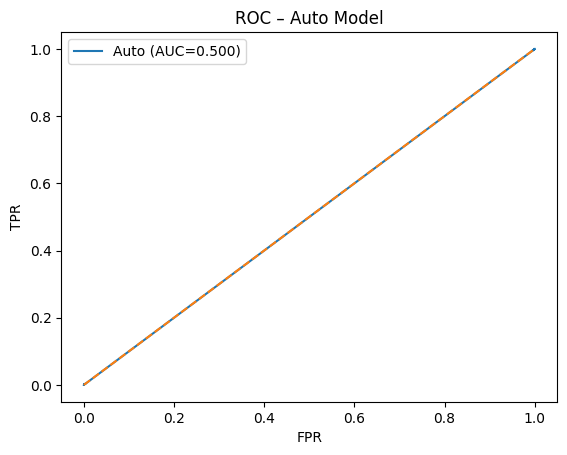

In [5]:
def eval_model(name, model):
    proba = model.predict(X_test_seq).ravel()
    pred  = (proba > 0.5).astype(int)
    
    acc   = accuracy_score(y_test_seq, pred)
    f1    = f1_score(y_test_seq, pred)
    auc   = roc_auc_score(y_test_seq, proba)
    cm    = confusion_matrix(y_test_seq, pred)
    
    tp    = ((pred==1)&(y_test_seq==1)).sum()
    tn    = ((pred==0)&(y_test_seq==0)).sum()
    print(f"{name} Model:")
    print(f"  Accuracy    : {acc:.4f}")
    print(f"  F1 Score    : {f1:.4f}")
    print(f"  AUC‑ROC     : {auc:.4f}")
    print(f"  True Positives (correct UP)  : {tp}")
    print(f"  True Negatives (correct DOWN): {tn}")
    print(f"  Confusion Matrix:\n{cm}\n")
   
    # ROC curve
    fpr, tpr, _ = roc_curve(y_test_seq, proba)
    plt.figure()
    plt.plot(fpr, tpr, label=f'{name} (AUC={auc:.3f})')
    plt.plot([0,1],[0,1],'--')
    plt.title(f'ROC – {name} Model')
    plt.xlabel('FPR'); plt.ylabel('TPR')
    plt.legend(); plt.show()

eval_model("Auto",   auto_model)
